# Lecture 9 - Production Planning

## Header

In [1]:
# # Dependencies: Uncomment and run this cell if you don't have these packages 
# using Pkg
# Pkg.add("JuMP")
# Pkg.add("Gurobi")
# Pkg.add("Plots")

In [2]:
include("src/data.jl")
include("src/opt.jl")
include("src/out.jl")

plot_plan (generic function with 1 method)

## Data Input

We'll use Gurobi, but you can subsitute your own optimizer here.

In [3]:
env = Gurobi.Env()
optimizer = () -> Gurobi.Optimizer(env);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-18


Generate instance data.

In [4]:
n_periods = 20
unit_cost = 1.0
holding_cost = 1.0
fixed_cost = 50.0
dat = ProductionInstance(n_periods, unit_cost, holding_cost, fixed_cost)

Production Planning Instance with 20 periods

## Basic Problem

Build the model, solve the problem, and plot the production plan.


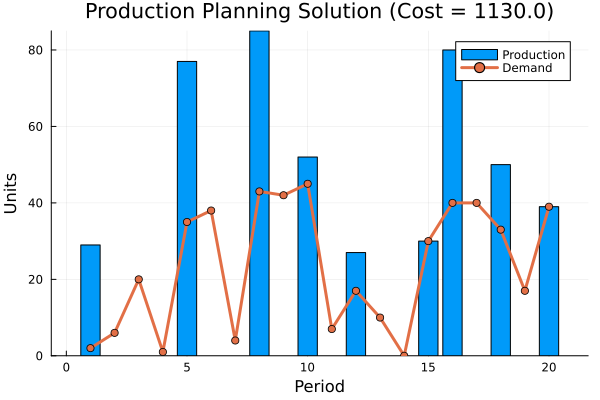

In [5]:
mdl = ProductionModel(dat, optimizer = optimizer, silent = true)
solution = solve!(mdl)
plot_plan(solution)

## Extended Formulation

Now we'll take a look at the LP relaxation. The basic formulation has a big integrality gap...

In [6]:
JuMP.relax_integrality(mdl.model)
JuMP.optimize!(mdl.model)
println("LP Objective Value:\t", round(objective_value(mdl.model), digits=2))
println("IP Objective Value:\t", round(solution.objective_value, digits=2))

LP Objective Value:	519.0
IP Objective Value:	1130.0


But the extended formulation is tight!

In [7]:
extend_formulation!(mdl)
JuMP.optimize!(mdl.model)
println("LP Objective Value:\t", round(objective_value(mdl.model), digits=2))
println("IP Objective Value:\t", round(solution.objective_value, digits=2))

LP Objective Value:	1130.0
IP Objective Value:	1130.0
